# Filtrage temporel de l'OLR

Auteur : FERRY Frédéric (ENM/C3M) - février 2021

In [92]:
%matplotlib inline

import os
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import scipy
import math
from scipy import signal,fftpack, interpolate
from scipy.interpolate import griddata

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.util import add_cyclic_point

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import IPython.display as IPdisplay, matplotlib.font_manager as fm
from PIL import Image
import glob

import warnings
warnings.filterwarnings("ignore")

In [93]:
dir_data='./data/'
dir_figs='./figs/'
dir_anim='./anim/'
if not os.path.exists(dir_figs):
    os.makedirs(dir_figs)
if not os.path.exists(dir_anim):
    os.makedirs(dir_anim)

# Calcul des anomalies quotidiennes

In [94]:
year1='2000'
year2='2019'
latS=-30.
latN=30.

olr    = xr.open_dataset(dir_data+'olr.day.mean.nc').sel(time=slice(year1,year2)).sel(lat=slice(latN,latS))

print(' ----- Computing daily anomalies ----- ')
olr_anom=olr.groupby('time.dayofyear') - olr.groupby('time.dayofyear').mean('time')

print(olr_anom)

print(' ----- Writing netcdf ----- ')
dataDIR = './result/olr.anom.'+year1+'-'+year2+'.nc'
olr_anom.to_netcdf(dataDIR)

 ----- Computing daily anomalies ----- 
<xarray.Dataset>
Dimensions:    (lon: 144, lat: 25, time: 7305, nmiss: 7)
Coordinates:
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 30.0 27.5 25.0 22.5 ... -22.5 -25.0 -27.5 -30.0
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2019-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Dimensions without coordinates: nmiss
Data variables:
    info       (time, nmiss) float32 -302.5 1.55 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    olr        (time, lat, lon) float32 -17.65 -28.66 -34.3 ... 6.875 6.71 4.538
 ----- Writing netcdf ----- 


In [100]:
season_name='NDJFM'
#season_name='MJJAS'

# Données entre 15S et 15N
data_olr=olr_anom.sel(lat=slice(30,-30))
lat = data_olr.lat.values
lon = data_olr.lon.values
time = data_olr.time.values

# Période totale des données
print(time)
d1=time[0]
d2=time[-1]
dates = pd.date_range(d1, d2, freq='D')
print(dates)

# Select Season
if season_name == 'NDJFM':
    months=np.any([dates.month==11,dates.month==12,dates.month==1,dates.month==2,dates.month==3],axis=0)
if season_name == 'MJJAS':
    months=np.any([dates.month==5,dates.month==6,dates.month==7,dates.month==8,dates.month==9],axis=0)

dates2=dates[months]
print(dates2)

data_season = data_olr.sel(time=dates2)
time = data_season.time.values
data=data_season['olr']

['2000-01-01T00:00:00.000000000' '2000-01-02T00:00:00.000000000'
 '2000-01-03T00:00:00.000000000' ... '2019-12-29T00:00:00.000000000'
 '2019-12-30T00:00:00.000000000' '2019-12-31T00:00:00.000000000']
DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', length=7305, freq='D')
DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
   

# Filtres

In [101]:
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

In [107]:
# window length for filters
window = 50

var=np.var(data, axis=0)
print(var)

############################################
day1=2.
day2=6.

# construct low pass filters
hfw = low_pass_weights(window, 1. / day1)
lfw = low_pass_weights(window, 1. / day2)
weight_high = xr.DataArray(hfw, dims = ['window'])
weight_low = xr.DataArray(lfw, dims = ['window'])

# apply the filters using the rolling method with the weights
lowpass_hf = data.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
lowpass_lf = data.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)

# the bandpass is the difference of two lowpass filters.
bandpass2_6= lowpass_hf - lowpass_lf

var2_6 = xr.DataArray.var(bandpass2_6, dim = 'time', skipna = True)
print(var2_6)

############################################
day1=6.
day2=20.

# construct low pass filters
hfw = low_pass_weights(window, 1. / day1)
lfw = low_pass_weights(window, 1. / day2)
weight_high = xr.DataArray(hfw, dims = ['window'])
weight_low = xr.DataArray(lfw, dims = ['window'])

# apply the filters using the rolling method with the weights
lowpass_hf = data.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
lowpass_lf = data.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)

# the bandpass is the difference of two lowpass filters.
bandpass6_30= lowpass_hf - lowpass_lf

var6_30 = xr.DataArray.var(bandpass6_30, dim = 'time', skipna = True)
print(var6_30)

############################################
day1=20.
day2=90.

# construct low pass filters
hfw = low_pass_weights(window, 1. / day1)
lfw = low_pass_weights(window, 1. / day2)
weight_high = xr.DataArray(hfw, dims = ['window'])
weight_low = xr.DataArray(lfw, dims = ['window'])

# apply the filters using the rolling method with the weights
lowpass_hf = data.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
lowpass_lf = data.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)

# the bandpass is the difference of two lowpass filters.
bandpass30_90= lowpass_hf - lowpass_lf

var30_90 = xr.DataArray.var(bandpass30_90, dim = 'time', skipna = True)
print(var30_90)

############################################
day1=120.
day2=100000.

# construct low pass filters
hfw = low_pass_weights(window, 1. / day1)
lfw = low_pass_weights(window, 1. / day2)
weight_high = xr.DataArray(hfw, dims = ['window'])
weight_low = xr.DataArray(lfw, dims = ['window'])

# apply the filters using the rolling method with the weights
lowpass_hf = data.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
lowpass_lf = data.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)

# the bandpass is the difference of two lowpass filters.
bandpass_low= lowpass_hf - lowpass_lf

var_low = xr.DataArray.var(bandpass_low, dim = 'time', skipna = True)
print(var_low)

<xarray.DataArray 'olr' (lat: 25, lon: 144)>
array([[522.736   , 488.99536 , 555.46295 , ..., 636.9397  , 553.89386 ,
        539.53467 ],
       [658.3557  , 670.09467 , 658.43365 , ..., 600.8167  , 638.3146  ,
        586.28534 ],
       [813.7942  , 847.182   , 741.64667 , ..., 843.49347 , 874.04047 ,
        787.729   ],
       ...,
       [ 91.18202 ,  87.008194,  86.19691 , ..., 134.31258 , 135.83932 ,
        103.09952 ],
       [127.5161  , 101.37142 , 110.27046 , ..., 195.14548 , 164.385   ,
        146.95633 ],
       [183.0541  , 145.30147 , 147.27078 , ..., 349.437   , 263.0507  ,
        217.67258 ]], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 30.0 27.5 25.0 22.5 20.0 ... -22.5 -25.0 -27.5 -30.0
<xarray.DataArray (lat: 25, lon: 144)>
array([[202.95072165, 187.85840044, 224.53449174, ..., 230.29010283,
        212.03614469, 212.00755162],
       [233.15309606, 237.43578102, 232.07925637,

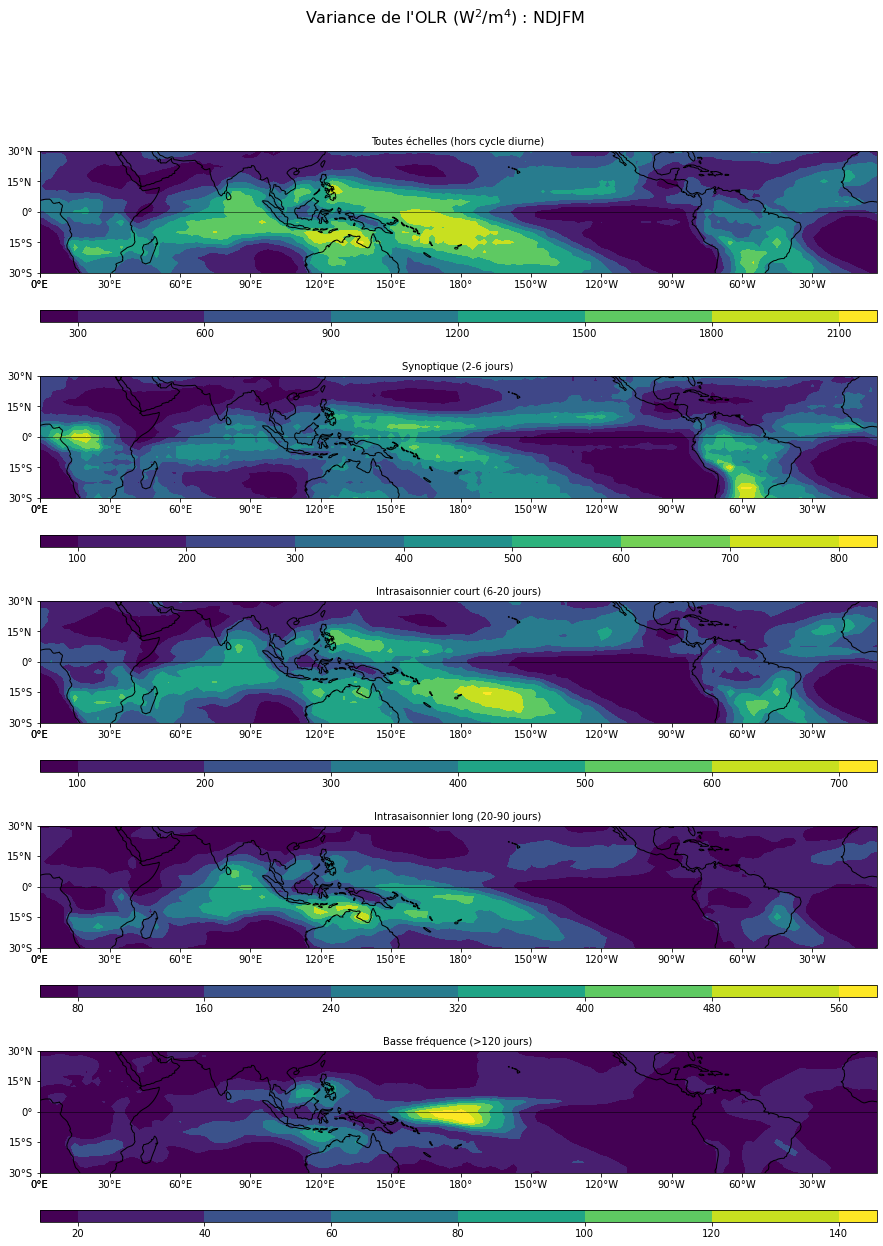

In [108]:
lonW=lon[0]
lonE=lon[-1]

bounds = [(lonW, lonE, -30, 30)]

def plot_background(ax):
    ax.set_xticks(np.linspace(0, 360, 13), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(latS, latN, 5), crs=ccrs.PlateCarree())
    ax.axes.axis('tight')
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.coastlines()
    ax.plot([0,180],[0,0],color='k',linewidth=0.5,transform=ccrs.PlateCarree())
    ax.plot([-180,0],[0,0],color='k',linewidth=0.5,transform=ccrs.PlateCarree())
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    return ax

cmap='viridis'

fig = plt.figure(figsize=(15., 20.))
fig.suptitle("Variance de l'OLR (W$^2$/m$^4$) : "+season_name, fontsize=16)

ax = fig.add_subplot(511, projection=ccrs.PlateCarree(central_longitude=180))
plot_background(ax)
ax.set_title('Toutes échelles (hors cycle diurne)', fontsize=10)
cf = ax.contourf(lon, lat, var,  transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')

ax = fig.add_subplot(512, projection=ccrs.PlateCarree(central_longitude=180))
plot_background(ax)
ax.set_title('Synoptique (2-6 jours)', fontsize=10)
cf = ax.contourf(lon, lat, var2_6,  transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')

ax = fig.add_subplot(513, projection=ccrs.PlateCarree(central_longitude=180))
plot_background(ax)
ax.set_title('Intrasaisonnier court (6-20 jours)', fontsize=10)
cf = ax.contourf(lon, lat, var6_30,  transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')

ax = fig.add_subplot(514, projection=ccrs.PlateCarree(central_longitude=180))
plot_background(ax)
ax.set_title('Intrasaisonnier long (20-90 jours)', fontsize=10)
cf = ax.contourf(lon, lat, var30_90,  transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')

ax = fig.add_subplot(515, projection=ccrs.PlateCarree(central_longitude=180))
plot_background(ax)
ax.set_title('Basse fréquence (>120 jours)', fontsize=10)
cf = ax.contourf(lon, lat, var_low,  transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')

figname='./figs/OLR_bandpass_variance_'+season_name
fig.savefig(figname+'.png')
plt.show()

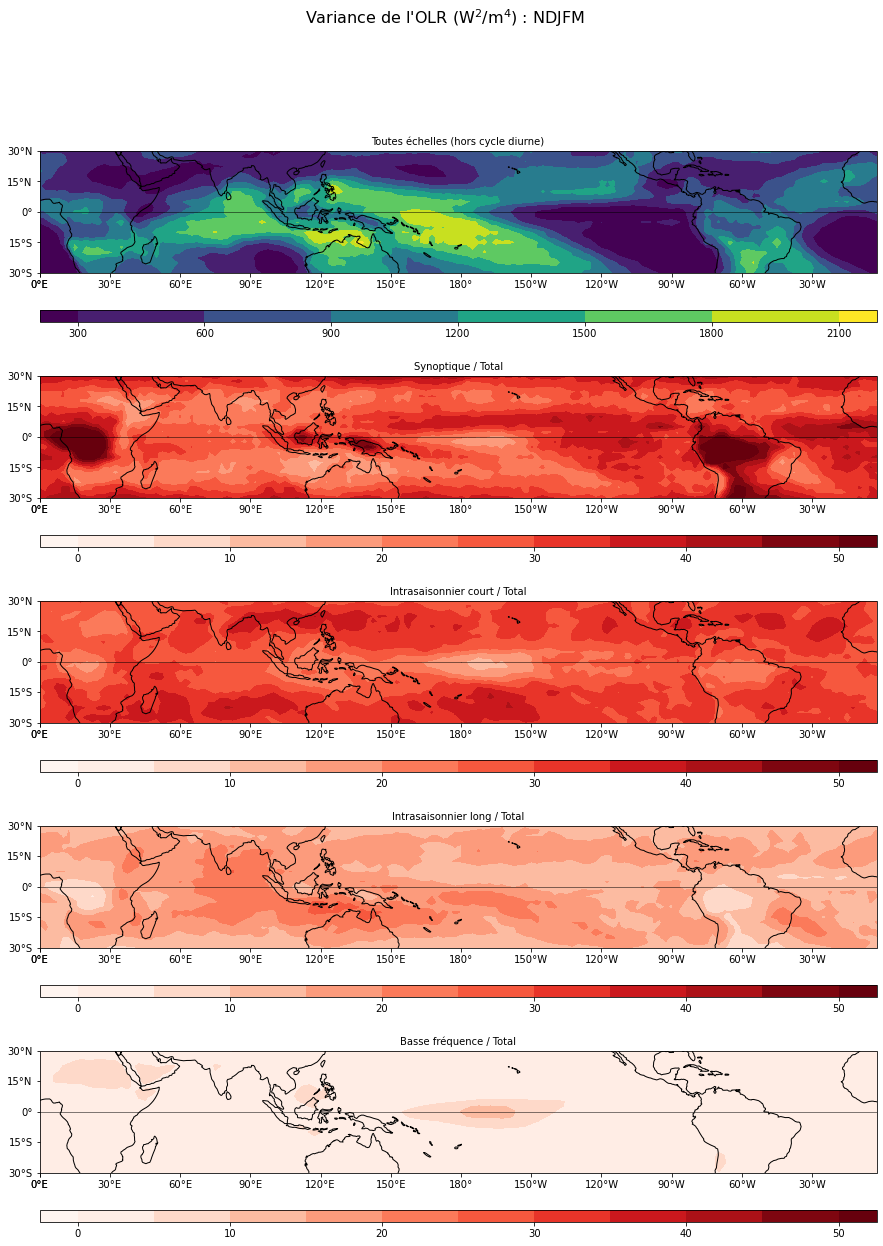

In [109]:
lonW=lon[0]
lonE=lon[-1]

bounds = [(lonW, lonE, -30, 30)]
levels=np.arange(0,55,5)

def plot_background(ax):
    ax.set_xticks(np.linspace(0, 360, 13), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(latS, latN, 5), crs=ccrs.PlateCarree())
    ax.axes.axis('tight')
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.coastlines()
    ax.plot([0,180],[0,0],color='k',linewidth=0.5,transform=ccrs.PlateCarree())
    ax.plot([-180,0],[0,0],color='k',linewidth=0.5,transform=ccrs.PlateCarree())
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    return ax

cmap2='Reds'

fig = plt.figure(figsize=(15., 20.))
fig.suptitle("Variance de l'OLR (W$^2$/m$^4$) : "+season_name, fontsize=16)

ax = fig.add_subplot(511, projection=ccrs.PlateCarree(central_longitude=180))
plot_background(ax)
ax.set_title('Toutes échelles (hors cycle diurne)', fontsize=10)
cf = ax.contourf(lon, lat, var,  transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')

ax = fig.add_subplot(512, projection=ccrs.PlateCarree(central_longitude=180))
plot_background(ax)
ax.set_title('Synoptique / Total', fontsize=10)
cf = ax.contourf(lon, lat, 100*var2_6/var, levels, transform=ccrs.PlateCarree(), cmap=cmap2, extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')

ax = fig.add_subplot(513, projection=ccrs.PlateCarree(central_longitude=180))
plot_background(ax)
ax.set_title('Intrasaisonnier court / Total', fontsize=10)
cf = ax.contourf(lon, lat, 100*var6_30/var, levels, transform=ccrs.PlateCarree(), cmap=cmap2, extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')

ax = fig.add_subplot(514, projection=ccrs.PlateCarree(central_longitude=180))
plot_background(ax)
ax.set_title('Intrasaisonnier long / Total', fontsize=10)
cf = ax.contourf(lon, lat, 100*var30_90/var, levels, transform=ccrs.PlateCarree(), cmap=cmap2, extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')

ax = fig.add_subplot(515, projection=ccrs.PlateCarree(central_longitude=180))
plot_background(ax)
ax.set_title('Basse fréquence / Total', fontsize=10)
cf = ax.contourf(lon, lat, 100*var_low/var, levels, transform=ccrs.PlateCarree(), cmap=cmap2, extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')

figname='./figs/OLR_bandpass_variance2_'+season_name
fig.savefig(figname+'.png')
plt.show()